## Looking inside the pipeline

In [2]:
!pip install transformers

In [ ]:
# from transformers import CLIPTextModel, CLIPTokenizer
# import torch
!pip install diffusers

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [ ]:
from diffusers import AutoencoderKL, UNet2DConditionModel
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

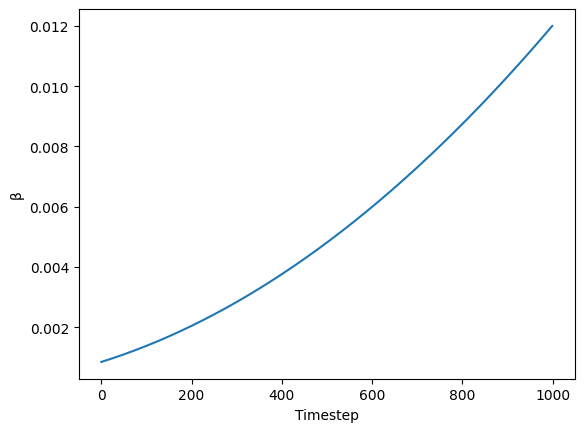

In [14]:
import matplotlib.pyplot as plt
beta_start,beta_end = 0.00085,0.012
plt.plot(torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2)
plt.xlabel('Timestep')
plt.ylabel('β');

In [89]:
from diffusers import LMSDiscreteScheduler
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)


In [90]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [91]:
text_input = tokenizer(prompt, padding='max_length',max_length = tokenizer.model_max_length,truncation = True)
text_input

{'input_ids': [[49406, 320, 8853, 539, 550, 18376, 6765, 320, 4558, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [92]:
tokenizer.decode(10668)

'uber'

In [93]:
text_embeddings = text_encoder(torch.tensor(text_input.input_ids).to("cuda"))[0].half()
text_embeddings.shape

torch.Size([1, 77, 768])

In [94]:
text_embeddings

tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
         [ 0.0292, -1.3242,  0.3076,  ..., -0.5254,  0.9766,  0.6655],
         [ 0.4609,  0.5610,  1.6689,  ..., -1.9502, -1.2266,  0.0093],
         ...,
         [-3.0410, -0.0674, -0.1777,  ...,  0.3950, -0.0174,  0.7671],
         [-3.0566, -0.1058, -0.1936,  ...,  0.4258, -0.0184,  0.7588],
         [-2.9844, -0.0850, -0.1726,  ...,  0.4373,  0.0092,  0.7490]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>)

In [95]:
max_length = torch.tensor(text_input.input_ids).shape[-1]
uncond_input = tokenizer([""] * batch_size, padding = 'max_length',max_length =max_length,return_tensors = 'pt')
uncond_embeddings = text_encoder(torch.tensor(uncond_input.input_ids).to('cuda'))[0].half()
uncond_embeddings.shape

<ipython-input-95-601e001ae23f>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uncond_embeddings = text_encoder(torch.tensor(uncond_input.input_ids).to('cuda'))[0].half()


torch.Size([1, 77, 768])

In [96]:
text_embeddings = torch.cat([uncond_embeddings,text_embeddings])

In [97]:
torch.manual_seed(100)
latents = torch.randn((batch_size,unet.in_channels,height //8, width // 8))
latents = latents.to('cuda').half()
latents.shape

<ipython-input-97-7bafe7093850>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size,unet.in_channels,height //8, width // 8))


torch.Size([1, 4, 64, 64])

In [98]:
scheduler.set_timesteps(num_inference_steps)

In [99]:
latents = latents * scheduler.init_noise_sigma


In [100]:
scheduler.timesteps

tensor([999.0000, 984.5217, 970.0435, 955.5652, 941.0870, 926.6087, 912.1304,
        897.6522, 883.1739, 868.6957, 854.2174, 839.7391, 825.2609, 810.7826,
        796.3043, 781.8261, 767.3478, 752.8696, 738.3913, 723.9130, 709.4348,
        694.9565, 680.4783, 666.0000, 651.5217, 637.0435, 622.5652, 608.0870,
        593.6087, 579.1304, 564.6522, 550.1739, 535.6957, 521.2174, 506.7391,
        492.2609, 477.7826, 463.3044, 448.8261, 434.3478, 419.8696, 405.3913,
        390.9131, 376.4348, 361.9565, 347.4783, 333.0000, 318.5217, 304.0435,
        289.5652, 275.0869, 260.6087, 246.1304, 231.6522, 217.1739, 202.6956,
        188.2174, 173.7391, 159.2609, 144.7826, 130.3044, 115.8261, 101.3478,
         86.8696,  72.3913,  57.9130,  43.4348,  28.9565,  14.4783,   0.0000])

In [101]:
scheduler.sigmas

tensor([14.6146, 13.3974, 12.3033, 11.3184, 10.4301,  9.6279,  8.9020,  8.2443,
         7.6472,  7.1044,  6.6102,  6.1594,  5.7477,  5.3709,  5.0258,  4.7090,
         4.4178,  4.1497,  3.9026,  3.6744,  3.4634,  3.2680,  3.0867,  2.9183,
         2.7616,  2.6157,  2.4794,  2.3521,  2.2330,  2.1213,  2.0165,  1.9180,
         1.8252,  1.7378,  1.6552,  1.5771,  1.5031,  1.4330,  1.3664,  1.3030,
         1.2427,  1.1852,  1.1302,  1.0776,  1.0272,  0.9788,  0.9324,  0.8876,
         0.8445,  0.8029,  0.7626,  0.7236,  0.6858,  0.6490,  0.6131,  0.5781,
         0.5438,  0.5102,  0.4770,  0.4443,  0.4118,  0.3795,  0.3470,  0.3141,
         0.2805,  0.2455,  0.2084,  0.1672,  0.1174,  0.0292,  0.0000])

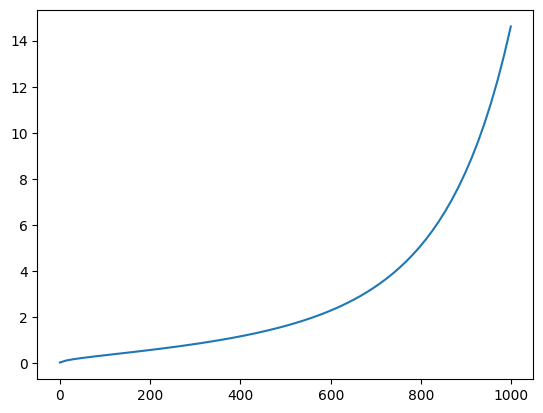

In [102]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1]);


In [103]:
from tqdm.auto import tqdm

In [104]:
for i,t in enumerate(tqdm(scheduler.timesteps)):
  input = torch.cat([latents]*2)
  input = scheduler.scale_model_input(input,t)

  # predict the noise residual
  with torch.no_grad():
    pred = unet(input,t,encoder_hidden_states = text_embeddings).sample

  # perform guidance
  pred_uncond,pred_text = pred.chunk(2)
  pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

  # compute the 'prev' noisy sample
  latents = scheduler.step(pred,t,latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [105]:
with torch.no_grad(): image = vae.decode(1/0.18215 * latents).sample

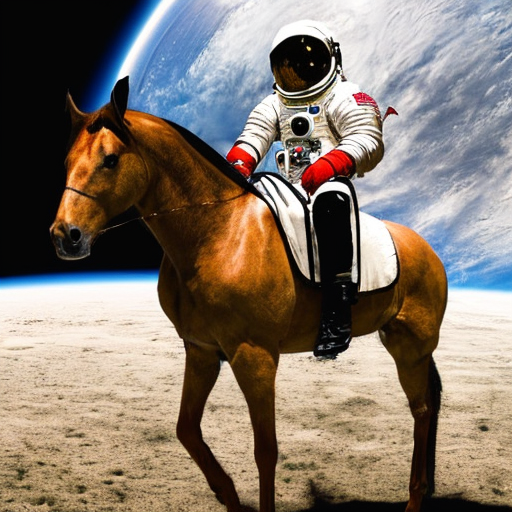

In [106]:
from PIL import Image
image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1,2,0).numpy()
image = (image * 255).round().astype('uint8')
Image.fromarray(image)

In [107]:
prompts = [
    'a photograph of an astronaut riding a horse',
    'an oil painting of an astronaut riding a horse in the style of grant wood'
]

In [108]:
text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()

In [109]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * len(prompts), padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()
emb = torch.cat([uncond_embeddings, text_embeddings])

In [110]:
torch.manual_seed(100)
g = guidance_scale

In [111]:
latents = torch.randn((len(prompts), unet.in_channels, height//8, width//8))
scheduler.set_timesteps(num_inference_steps)
latents = latents.to("cuda").half() * scheduler.init_noise_sigma

<ipython-input-111-9660cc1796ba>:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((len(prompts), unet.in_channels, height//8, width//8))


In [112]:
for i,ts in enumerate(tqdm(scheduler.timesteps)):
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
    with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
    pred = u + g*(t-u)
    latents = scheduler.step(pred, ts, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [113]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample
res = (image / 2 + 0.5).clamp(0, 1)

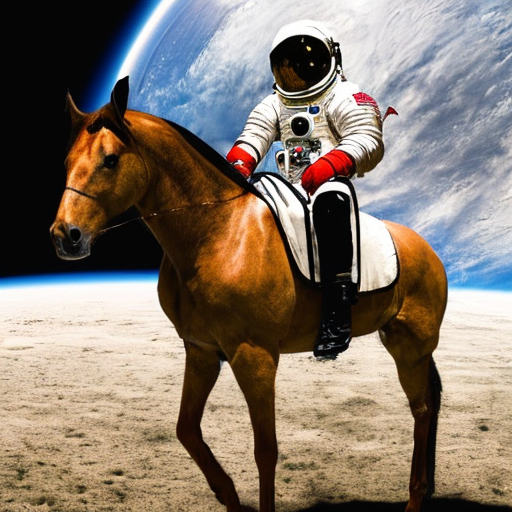

In [114]:
image = res[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

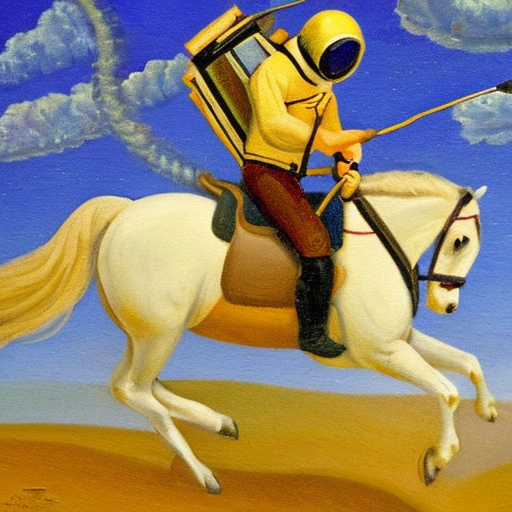

In [115]:
image = res[1].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

In [116]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

def mk_samples(prompts, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [131]:
prompts = ["cube cutout of an isometric programmer's bedroom, 3d art, professional colors, soft lighting, high detail, artstation, concept art, behance, ray tracing",
           "Portrait of an owl, steampunk, indigo blue, colorful, illustration, highly detailed, simple, smooth, and clean vector, no jagged lines, vector art, smooth, made all with grey colored gears inspired by future technology"]
images = mk_samples(prompts)


<ipython-input-116-6cba26910542>:17: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

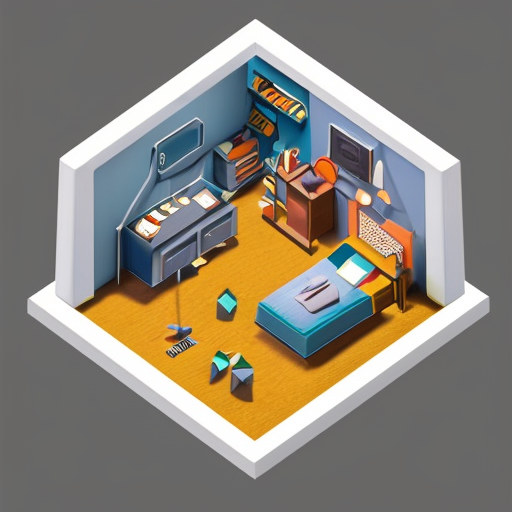

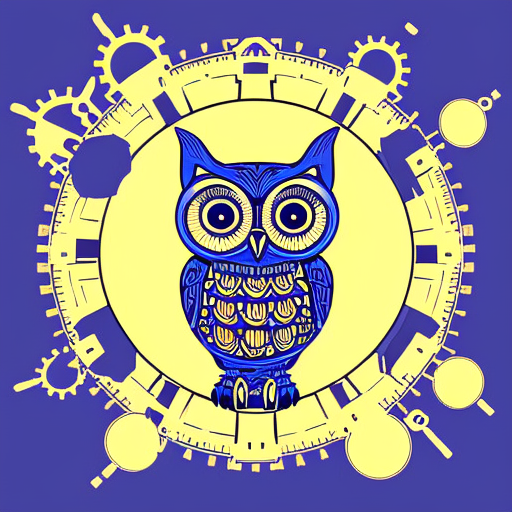

In [132]:
from IPython.display import display
for img in images: display(mk_img(img))